# online market simulator

## part1 : data preparation

In [7]:
from preparation.preparation import load_data,clean_data, summarize_data

df = load_data("data.xlsx")
df_clean = clean_data(df)
summary = summarize_data(df_clean)
summary.head()
print(summary)

✅ Data loaded successfully! Shape: (525461, 8)
✅ Data cleaned! Remaining rows: 504731
✅ Summary created! 4495 unique products.
                           Description   AvgPrice  TotalQuantity  \
0                *boombox ipod classic  16.980000              1   
1             *usb office glitter lamp   8.650000              1   
2              *usb office mirror ball   8.650000              1   
3               10 colour spaceboy pen   0.980816           6142   
4       11 pc ceramic tea set polkadot   4.950000              3   
...                                ...        ...            ...   
4490      zinc heart lattice tray oval   5.971364            326   
4491       zinc metal heart decoration   1.387674          14120   
4492           zinc police box lantern   7.395000            195   
4493     zinc top  2 door wooden shelf  12.159091            237   
4494  zinc willie winkie  candle stick   1.085273           3950   

      UniqueCustomers  
0                   0  
1       

## part 2 : modeling sellers (you can see seller implementation in modeling package)

### example of sellers and their influencers network

In [8]:
from modeling.seller import Seller
from config.constants import COST,ALPHA,BETA,GAMMA,BASE_DEMAND


# Create sellers
s1 = Seller("Seller A", price=30, ad_budget=10, cost=COST, alpha=ALPHA, beta=BETA, gamma=GAMMA, base_demand=BASE_DEMAND)
s2 = Seller("Seller B", price=32, ad_budget=12, cost=COST, alpha=ALPHA, beta=BETA, gamma=GAMMA, base_demand=BASE_DEMAND)
s3 = Seller("Seller C", price=29, ad_budget=8, cost=COST, alpha=ALPHA, beta=BETA, gamma=GAMMA, base_demand=BASE_DEMAND)

sellers = [s1, s2, s3]

# Suppose we have influence scores from a social network later
influence_scores = {"Seller A": 5, "Seller B": 3, "Seller C": 2}

# Compute demand & profit for each seller
for s in sellers:
    s.compute_demand(sellers, influence_scores[s.name])
    s.compute_profit()

for s in sellers:
    print(s)


Seller(Seller A: Price=30, Ads=10, Profit=1210.00, Demand=61.00)
Seller(Seller B: Price=32, Ads=12, Profit=1176.00, Demand=54.00)
Seller(Seller C: Price=29, Ads=8, Profit=1132.00, Demand=60.00)


## part3 : market simulation and Nash Equilibrium

In [11]:
from market.simulation import simulate_market


# Simulate market dynamics
sellers_eq, history = simulate_market(sellers, influence_scores)

# Print final equilibrium states
print("\n🎯 Final Equilibrium States:")
for s in sellers_eq:
    print(f"{s.name}: Price={s.price:.2f}, Ads={s.ad_budget:.2f}, Profit={s.profit:.2f}")

print(history)

✅ Equilibrium reached after 1 iterations.

🎯 Final Equilibrium States:
Seller A: Price=31.00, Ads=12.00, Profit=1269.00
Seller B: Price=32.00, Ads=14.00, Profit=1240.00
Seller C: Price=31.00, Ads=10.00, Profit=1208.00
[3717.0]


plot the simulation iteration

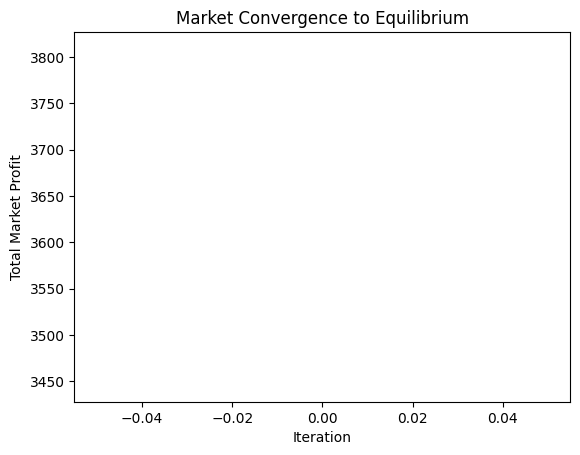

In [10]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Total Market Profit")
plt.title("Market Convergence to Equilibrium")
plt.show()